# Simple IMPT plan optimization

In [ ]:
import math
import os
import sys

import numpy as np
from matplotlib import pyplot as plt

from opentps.core.data.images import CTImage
from opentps.core.data.images import ROIMask
from opentps.core.data.plan import ObjectivesList
from opentps.core.data.plan import PlanDesign
from opentps.core.data import DVH
from opentps.core.data import Patient
from opentps.core.data.plan import FidObjective
from opentps.core.io import mcsquareIO
from opentps.core.io.scannerReader import readScanner
from opentps.core.io.serializedObjectIO import saveRTPlan, loadRTPlan
from opentps.core.processing.doseCalculation.doseCalculationConfig import DoseCalculationConfig
from opentps.core.processing.doseCalculation.mcsquareDoseCalculator import MCsquareDoseCalculator
from opentps.core.processing.imageProcessing.resampler3D import resampleImage3DOnImage3D, resampleImage3D
from opentps.core.processing.planOptimization.planOptimization import IMPTPlanOptimizer

## CT calibration and BDL

In [14]:
ctCalibration = readScanner(DoseCalculationConfig().scannerFolder)
bdl = mcsquareIO.readBDL(DoseCalculationConfig().bdlFile)

## Create synthetic CT and ROI

In [15]:
patient = Patient()
patient.name = 'Patient'

ctSize = 150

ct = CTImage()
ct.name = 'CT'
ct.patient = patient


huAir = -1024.
huWater = ctCalibration.convertRSP2HU(1.)
data = huAir * np.ones((ctSize, ctSize, ctSize))
data[:, 50:, :] = huWater
ct.imageArray = data

roi = ROIMask()
roi.patient = patient
roi.name = 'TV'
roi.color = (255, 0, 0) # red
data = np.zeros((ctSize, ctSize, ctSize)).astype(bool)
data[100:120, 100:120, 100:120] = True
roi.imageArray = data

## Configure dose engine

In [16]:
mc2 = MCsquareDoseCalculator()
mc2.beamModel = bdl
mc2.nbPrimaries = 5e4
mc2.ctCalibration = ctCalibration

mc2._independentScoringGrid = True
scoringSpacing = [2, 2, 2]
mc2._scoringVoxelSpacing = scoringSpacing

## Design plan

In [5]:
beamNames = ["Beam1"]
gantryAngles = [0.]
couchAngles = [0.]

planInit = PlanDesign()
planInit.ct = ct
planInit.targetMask = roi
planInit.gantryAngles = gantryAngles
planInit.beamNames = beamNames
planInit.couchAngles = couchAngles
planInit.calibration = ctCalibration
planInit.spotSpacing = 6.0
planInit.layerSpacing = 6.0
planInit.targetMargin = 0.0
planInit.scoringVoxelSpacing = [2, 2, 2]

plan = planInit.buildPlan()  # Spot placement
plan.PlanName = "NewPlan"

beamlets = mc2.computeBeamlets(ct, plan, roi=[roi])
plan.planDesign.beamlets = beamlets
doseImageRef = beamlets.toDoseImage()

27/07/2023 04:37:25 PM - opentps.core.data.plan._planDesign - INFO - Building plan ...
27/07/2023 04:37:25 PM - opentps.core.processing.planOptimization.planInitializer - INFO - Target is dilated using a margin of 0.0 mm. This process might take some time.
27/07/2023 04:37:25 PM - opentps.core.processing.imageProcessing.roiMasksProcessing - INFO - Using SITK to dilate mask.
27/07/2023 04:37:28 PM - opentps.core.data.plan._planDesign - INFO - New plan created in 2.09409236907959 sec
27/07/2023 04:37:28 PM - opentps.core.data.plan._planDesign - INFO - Number of spots: 84
27/07/2023 04:37:28 PM - opentps.core.processing.doseCalculation.mcsquareDoseCalculator - INFO - Prepare MCsquare Beamlet calculation
27/07/2023 04:37:31 PM - opentps.core.io.mhdIO - INFO - Write MHD file: /home/eliot/openTPS_workspace/Simulations/MCsquare_simulation/CT.mhd
27/07/2023 04:37:31 PM - opentps.core.io.mcsquareIO - INFO - Write plan: /home/eliot/openTPS_workspace/Simulations/MCsquare_simulation/PlanPencil.txt

MCsquare: 7: [: Linux: unexpected operator





Initialization time: 0.598795 s 


Simulation of beamlet 84/84  
MC computation time: 2.801707 s 
Output computation time: 0.007629 s 

Simulation of beamlet 83/84  
MC computation time: 2.877325 s 
Output computation time: 0.006768 s 

Simulation of beamlet 76/84  
MC computation time: 2.908817 s 
Output computation time: 0.006957 s 

Simulation of beamlet 81/84  
MC computation time: 2.936700 s 
Output computation time: 0.006828 s 

Simulation of beamlet 73/84  
MC computation time: 2.936653 s 
Output computation time: 0.006867 s 

Simulation of beamlet 82/84  
MC computation time: 2.943382 s 
Output computation time: 0.006567 s 

Simulation of beamlet 79/84  
MC computation time: 2.952209 s 
Output computation time: 0.007394 s 

Simulation of beamlet 77/84  
MC computation time: 2.976436 s 
Output computation time: 0.006959 s 

Simulation of beamlet 80/84  
MC computation time: 2.979459 s 
Output computation time: 0.007112 s 

Simulation of beamlet 75/84  
MC computation time: 3.

## Objectives

In [9]:
plan.planDesign.objectives = ObjectivesList()
plan.planDesign.objectives.setTarget(roi.name, 20.0)

plan.planDesign.objectives.fidObjList = []
plan.planDesign.objectives.addFidObjective(roi, FidObjective.Metrics.DMAX, 20.0, 1.0)
plan.planDesign.objectives.addFidObjective(roi, FidObjective.Metrics.DMIN, 20.5, 1.0)

## Optimize plan

In [10]:
solver = IMPTPlanOptimizer(method='Scipy-LBFGS', plan=plan, maxit=50)
w, doseImage, ps = solver.optimize()

plan.spotMUs = np.square(w).astype(np.float32)

27/07/2023 05:25:45 PM - opentps.core.processing.planOptimization.planOptimization - INFO - Prepare optimization ...
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           84     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.69799D+02    |proj g|=  3.77717D+00
27/07/2023 05:25:45 PM - opentps.core.processing.planOptimization.solvers.bfgs - INFO - Iteration 1 of Scipy-L-BFGS-B

At iterate    1    f=  5.15872D+01    |proj g|=  2.16194D+00
27/07/2023 05:25:45 PM - opentps.core.processing.planOptimization.solvers.bfgs - INFO - objective = 5.158724e+01  
27/07/2023 05:25:45 PM - opentps.core.processing.planOptimization.solvers.bfgs - INFO - Iteration 2 of Scipy-L-BFGS-B

At iterate    2    f=  3.98964D+01    |proj g|=  3.81632D+00
27/07/2023 05:25:45 PM - opentps.core.processing.planOptimization.solvers.bfgs - INFO - objective = 3.989635e+01  
27/07/2023 05:25:45 PM - opentps.core.processing.planOptimizatio

 This problem is unconstrained.


27/07/2023 05:25:45 PM - opentps.core.processing.planOptimization.solvers.bfgs - INFO - Iteration 21 of Scipy-L-BFGS-B

At iterate   21    f=  7.34621D+00    |proj g|=  2.17151D-02
27/07/2023 05:25:45 PM - opentps.core.processing.planOptimization.solvers.bfgs - INFO - objective = 7.346209e+00  
27/07/2023 05:25:45 PM - opentps.core.processing.planOptimization.solvers.bfgs - INFO - Iteration 22 of Scipy-L-BFGS-B

At iterate   22    f=  7.34110D+00    |proj g|=  3.21667D-02
27/07/2023 05:25:45 PM - opentps.core.processing.planOptimization.solvers.bfgs - INFO - objective = 7.341099e+00  
27/07/2023 05:25:45 PM - opentps.core.processing.planOptimization.solvers.bfgs - INFO - Iteration 23 of Scipy-L-BFGS-B

At iterate   23    f=  7.33356D+00    |proj g|=  4.47038D-02
27/07/2023 05:25:45 PM - opentps.core.processing.planOptimization.solvers.bfgs - INFO - objective = 7.333561e+00  
27/07/2023 05:25:45 PM - opentps.core.processing.planOptimization.solvers.bfgs - INFO - Iteration 24 of Scipy-L-

## Final dose computation

In [18]:
mc2.nbPrimaries = 1e7
doseImage = mc2.computeDose(ct, plan)

27/07/2023 05:27:22 PM - opentps.core.processing.doseCalculation.mcsquareDoseCalculator - INFO - Prepare MCsquare Dose calculation
27/07/2023 05:27:22 PM - opentps.core.io.mhdIO - INFO - Write MHD file: /home/eliot/openTPS_workspace/Simulations/MCsquare_simulation/CT.mhd
27/07/2023 05:27:22 PM - opentps.core.io.mcsquareIO - INFO - Write plan: /home/eliot/openTPS_workspace/Simulations/MCsquare_simulation/PlanPencil.txt
27/07/2023 05:27:23 PM - opentps.core.processing.doseCalculation.mcsquareDoseCalculator - INFO - Start MCsquare simulation


MCsquare: 7: [: Linux: unexpected operator





Initialization time: 0.639518 s 


Simulation started (2023-07-27 17:27:23) 
 10.0 % 
 20.0 % 
 30.0 % 
 40.0 % 
 50.0 % (stat uncertainty: 0.61 %) 
 60.0 % (stat uncertainty: 0.59 %) 
 70.0 % (stat uncertainty: 0.55 %) 
 80.0 % (stat uncertainty: 0.52 %) 
 90.0 % (stat uncertainty: 0.49 %) 
 100.0 % (stat uncertainty: 0.47 %) 

Nbr primaries simulated: 10000000 (98511 generated outside the geometry) 
MC computation time: 14.883702 s 
Output computation time: 0.002013 s 

Total computation time: 15.525250 s 


## Plots

D95 = 15.10009765625 Gy
D5 = 23.32763671875 Gy
D5 - D95 =  8.2275390625 Gy
27/07/2023 05:27:40 PM - opentps.core.processing.imageProcessing.roiMasksProcessing - INFO - Using SITK to dilate mask.


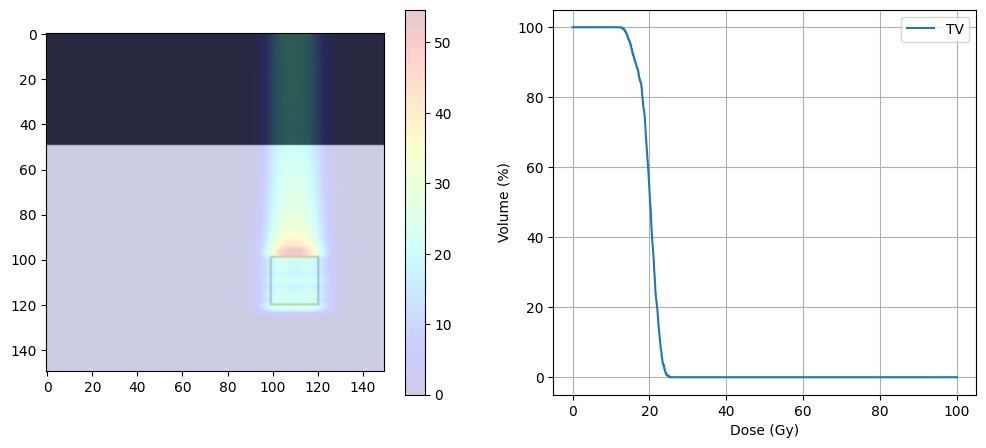

In [19]:
 # Compute DVH on resampled contour
roiResampled = resampleImage3D(roi, origin=ct.origin, gridSize=scoringGridSize, spacing=scoringSpacing)
target_DVH = DVH(roiResampled, doseImage)
print('D95 = ' + str(target_DVH.D95) + ' Gy')
print('D5 = ' + str(target_DVH.D5) + ' Gy')
print('D5 - D95 =  {} Gy'.format(target_DVH.D5 - target_DVH.D95))

# center of mass
roi = resampleImage3DOnImage3D(roi, ct)
COM_coord = roi.centerOfMass
COM_index = roi.getVoxelIndexFromPosition(COM_coord)
Z_coord = COM_index[2]

img_ct = ct.imageArray[:, :, Z_coord].transpose(1, 0)
contourTargetMask = roi.getBinaryContourMask()
img_mask = contourTargetMask.imageArray[:, :, Z_coord].transpose(1, 0)
img_dose = resampleImage3DOnImage3D(doseImage, ct)
img_dose = img_dose.imageArray[:, :, Z_coord].transpose(1, 0)

# Display dose
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
#ax[0].axes.get_xaxis().set_visible(False)
#ax[0].axes.get_yaxis().set_visible(False)
ax[0].imshow(img_ct, cmap='gray')
ax[0].imshow(img_mask, alpha=.2, cmap='binary')  # PTV
dose = ax[0].imshow(img_dose, cmap='jet', alpha=.2)
plt.colorbar(dose, ax=ax[0])
ax[1].plot(target_DVH.histogram[0], target_DVH.histogram[1], label=target_DVH.name)
ax[1].set_xlabel("Dose (Gy)")
ax[1].set_ylabel("Volume (%)")
plt.grid(True)
plt.legend()

plt.show()